In [1]:
import os
import re
import json
import time
import random
from collections import Counter
import string
from typing import Dict, List, Tuple, Optional

# Data processing and numerical computations
import numpy as np
import pandas as pd
from PIL import Image
import warnings

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.cuda.amp import GradScaler, autocast

# Vision models and transformations
import torchvision.models as models
from torchvision import transforms
from torchvision.models import ResNet50_Weights


In [2]:
import torch
import json
import pandas as pd
import re
import string
from collections import Counter, defaultdict
from nltk.tokenize import word_tokenize
import numpy as np
from typing import Dict, List, Set

class EnhancedVocabBuilder:
    def __init__(self, min_freq=2):
        self.min_freq = min_freq
        self.word_counter = Counter()
        
        # Comprehensive special tokens with semantic grouping
        self.special_tokens = {
            # Basic tokens
            '<pad>': 0,
            '<unk>': 1,
            '<start>': 2,
            '<end>': 3,
            
            # Numeric tokens
            '<num>': 4,
            '<decimal>': 5,
            '<percent>': 6,
            
            # Temporal tokens
            '<year>': 7,
            '<month>': 8,
            '<date>': 9,
            
            # Trend tokens
            '<increase>': 10,
            '<decrease>': 11,
            '<stable>': 12,
            '<peak>': 13,
            '<low>': 14,
            
            # Comparison tokens
            '<higher>': 15,
            '<lower>': 16,
            '<equal>': 17,
            
            # Domain-specific tokens
            '<location>': 18,
            '<currency>': 19,
            '<unit>': 20,
            '<trend_start>': 21,
            '<trend_end>': 22
        }
        
        # Initialize vocabulary
        self.vocab = self.special_tokens.copy()
        
        # Initialize patterns
        self._compile_patterns()
        self._init_word_mappings()
    
    def _compile_patterns(self):
        """Compile all regex patterns for efficiency."""
        self.patterns = {
            'number': re.compile(r'\b\d+\b'),
            'decimal': re.compile(r'\d+\.\d+'),
            'percent': re.compile(r'(\d+(\.\d+)?)\s*%'),
            'year': re.compile(r'\b(19|20)\d{2}\b'),
            'date': re.compile(r'\d{1,2}(/|-)\d{1,2}(/|-)\d{2,4}')
        }
        
        self.compound_patterns = {
            'currency': [
                (r'\$\s*\d+', '<currency>'),
                (r'(usd|eur|gbp|dollars)', '<currency>'),
                (r'billion|million|thousand', '<unit>')
            ],
            'locations': [
                (r'\bu\.s\.|united states|america\b', '<location>'),
                (r'\buk\b|united kingdom\b', '<location>'),
                (r'\beu\b|european union\b', '<location>')
            ],
            'trends': [
                (r'increased (from|by|to)', '<trend_start>'),
                (r'decreased (from|by|to)', '<trend_start>'),
                (r'reached|amounted to', '<trend_end>')
            ]
        }
    
    def _init_word_mappings(self):
        """Initialize word mappings for special token conversion."""
        self.trend_words = {
            'increase': ['increase', 'increased', 'increasing', 'rises', 'rising', 'rose', 'grew', 'growth'],
            'decrease': ['decrease', 'decreased', 'decreasing', 'falls', 'falling', 'fell', 'decline', 'declined'],
            'stable': ['stable', 'steady', 'constant', 'unchanged', 'maintained'],
            'peak': ['peak', 'maximum', 'highest', 'top', 'peaked'],
            'low': ['low', 'minimum', 'lowest', 'bottom', 'bottomed']
        }
        
        self.months = set([
            'january', 'february', 'march', 'april', 'may', 'june',
            'july', 'august', 'september', 'october', 'november', 'december',
            'jan', 'feb', 'mar', 'apr', 'may', 'jun',
            'jul', 'aug', 'sep', 'oct', 'nov', 'dec'
        ])
        
        # Important words to keep
        self.important_words = {
            'by', 'to', 'from', 'between', 'and', 'in', 'at', 'of',
            'with', 'during', 'since', 'until'
        }
    
    def preprocess_text(self, text: str) -> str:
        """Enhanced text preprocessing with comprehensive pattern handling."""
        if not isinstance(text, str):
            return ""
        
        # Convert to lowercase and clean
        text = text.lower().strip()
        
        # Handle compound patterns first
        for pattern_group in self.compound_patterns.values():
            for pattern, replacement in pattern_group:
                text = re.sub(pattern, replacement, text)
        
        # Handle other patterns
        text = self._handle_dates(text)
        text = self._handle_numbers(text)
        text = self._handle_trends(text)
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Filter and clean tokens
        tokens = self._filter_tokens(tokens)
        
        return ' '.join(tokens)
    
    def _handle_numbers(self, text: str) -> str:
        """Handle numerical patterns in order of complexity."""
        # Handle percentages first
        text = self.patterns['percent'].sub(' <percent> ', text)
        
        # Handle decimals before integers
        text = self.patterns['decimal'].sub(' <decimal> ', text)
        text = self.patterns['number'].sub(' <num> ', text)
        
        return text
    
    def _handle_dates(self, text: str) -> str:
        """Handle all date-related patterns."""
        # Handle formatted dates
        text = self.patterns['date'].sub(' <date> ', text)
        text = self.patterns['year'].sub(' <year> ', text)
        
        # Handle month names
        words = text.split()
        text = ' '.join('<month>' if word in self.months else word 
                       for word in words)
        
        return text
    
    def _handle_trends(self, text: str) -> str:
        """Handle trend-related words with context awareness."""
        words = text.split()
        processed_words = []
        
        for word in words:
            replaced = False
            for trend_type, trend_list in self.trend_words.items():
                if word in trend_list:
                    processed_words.append(f'<{trend_type}>')
                    replaced = True
                    break
            if not replaced:
                processed_words.append(word)
        
        return ' '.join(processed_words)
    
    def _filter_tokens(self, tokens: List[str]) -> List[str]:
        """Filter tokens with enhanced rules."""
        return [token for token in tokens if (
            token in self.important_words or
            token.startswith('<') or
            token not in string.punctuation or
            len(token) > 1
        )]
    
    def build_vocab(self, metadata_file: str, verbose: bool = True) -> Dict[str, int]:
        """Build vocabulary with enhanced monitoring."""
        if verbose:
            print(f"Building enhanced vocabulary from: {metadata_file}")
        
        try:
            metadata = pd.read_csv(metadata_file)
            total_rows = len(metadata)
            token_frequencies = defaultdict(int)
            pattern_matches = defaultdict(int)
            
            for i, row in enumerate(metadata.iterrows()):
                for field in ['caption', 'xAxis', 'yAxis']:
                    if field in row[1] and pd.notna(row[1][field]):
                        processed_text = self.preprocess_text(str(row[1][field]))
                        tokens = processed_text.split()
                        
                        # Update counters
                        self.word_counter.update(tokens)
                        
                        # Track special token usage
                        for token in tokens:
                            if token.startswith('<') and token.endswith('>'):
                                token_frequencies[token] += 1
                
                if verbose and (i + 1) % 100 == 0:
                    print(f"Processed {i + 1}/{total_rows} rows...")
            
            # Build final vocabulary
            idx = len(self.vocab)
            for word, freq in self.word_counter.most_common():
                if freq >= self.min_freq and word not in self.vocab:
                    self.vocab[word] = idx
                    idx += 1
            
            if verbose:
                self._print_stats(token_frequencies)
            
            return self.vocab
            
        except Exception as e:
            print(f"Error building vocabulary: {str(e)}")
            return self.vocab
    
    def _print_stats(self, token_frequencies: Dict[str, int]):
        """Print comprehensive vocabulary statistics."""
        print("\nVocabulary Statistics:")
        print(f"Total vocabulary size: {len(self.vocab)}")
        print(f"Regular words: {len(self.vocab) - len(self.special_tokens)}")
        print(f"Special tokens: {len(self.special_tokens)}")
        
        print("\nSpecial Token Usage:")
        for token, freq in sorted(token_frequencies.items(), 
                                key=lambda x: x[1], reverse=True):
            print(f"{token}: {freq}")
        
        print("\nMost Common Words:")
        for word, freq in self.word_counter.most_common(30):
            print(f"{word}: {freq}")
    
    def save_vocab(self, path: str):
        """Save vocabulary with comprehensive metadata."""
        vocab_data = {
            'vocabulary': self.vocab,
            'special_tokens': self.special_tokens,
            'statistics': {
                'total_size': len(self.vocab),
                'special_tokens': len(self.special_tokens),
                'regular_tokens': len(self.vocab) - len(self.special_tokens),
                'most_common': dict(self.word_counter.most_common(50))
            }
        }
        
        with open(path, 'w') as f:
            json.dump(vocab_data, f, indent=2)

In [4]:

import torch
from torch.utils.data import Dataset
from PIL import Image
import json
import os
from torchvision import transforms

import pandas as pd
import numpy as np
from typing import Dict, List
from collections import defaultdict

class EnhancedGraphCaptionDataset(Dataset):
    def __init__(self, 
                 metadata_file: str,
                 vocab_file: str,
                 transform=None,
                 max_caption_length: int = 100):
        print("Initializing EnhancedGraphCaptionDataset...")
        
        # Load metadata
        self.metadata = pd.read_csv(metadata_file)
        print(f"Loaded metadata with {len(self.metadata)} samples")
        
        # Load vocabulary
        with open(vocab_file, 'r') as f:
            vocab_data = json.load(f)
            self.vocab = vocab_data['vocabulary']
            self.special_tokens = vocab_data['special_tokens']
        print(f"Loaded vocabulary with {len(self.vocab)} tokens")
        
        # Initialize parameters
        self.transform = transform or self._get_default_transform()
        self.max_caption_length = max_caption_length
        
        # Analyze caption lengths
        self._analyze_lengths()
        
        # Validate data
        self._validate_data()
    
    def _get_default_transform(self):
        """Get default image transforms."""
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    
    def _validate_data(self):
        """Validate all data paths and collect statistics."""
        print("\nValidating data...")
        self.valid_indices = []
        self.image_sizes = defaultdict(int)
        
        for idx, row in self.metadata.iterrows():
            try:
                # Validate image path
                img_path = row['imgPath']
                if os.path.exists(img_path):
                    with Image.open(img_path) as img:
                        self.image_sizes[img.size] += 1
                        self.valid_indices.append(idx)
            except Exception as e:
                print(f"Warning: Error processing image at index {idx}: {str(e)}")
        
        print(f"Found {len(self.valid_indices)} valid samples")
        print("\nImage size distribution:")
        for size, count in self.image_sizes.items():
            print(f"Size {size}: {count} images")
    
    def _analyze_lengths(self):
        """Analyze actual caption lengths."""
        self.caption_lengths = []
        self.x_lengths = []
        self.y_lengths = []
        
        for _, row in self.metadata.iterrows():
            # Get tokenized lengths without padding
            cap_tokens = self.tokenize_text(row['caption'], add_special_tokens=True, pad=False)
            x_tokens = self.tokenize_text(row['xAxis'], add_special_tokens=False, pad=False)
            y_tokens = self.tokenize_text(row['yAxis'], add_special_tokens=False, pad=False)
            
            self.caption_lengths.append(len(cap_tokens))
            self.x_lengths.append(len(x_tokens))
            self.y_lengths.append(len(y_tokens))
        
        # Calculate statistics
        self.length_stats = {
            'caption': {
                'mean': np.mean(self.caption_lengths),
                'median': np.median(self.caption_lengths),
                'max': max(self.caption_lengths),
                'min': min(self.caption_lengths),
                '95th': np.percentile(self.caption_lengths, 95)
            },
            'x_axis': {
                'mean': np.mean(self.x_lengths),
                'median': np.median(self.x_lengths),
                'max': max(self.x_lengths)
            },
            'y_axis': {
                'mean': np.mean(self.y_lengths),
                'median': np.median(self.y_lengths),
                'max': max(self.y_lengths)
            }
        }
        
        # Print length statistics
        print("\nSequence Length Statistics:")
        for key, stats in self.length_stats.items():
            print(f"\n{key}:")
            for stat_name, value in stats.items():
                print(f"{stat_name}: {value:.2f}")
    
    def tokenize_text(self, text: str, add_special_tokens: bool = True, pad: bool = True) -> List[int]:
        """Tokenize text with dynamic padding."""
        if not isinstance(text, str):
            text = str(text)
        
        # Initialize tokens
        tokens = []
        if add_special_tokens:
            tokens.append(self.special_tokens['<start>'])
        
        # Tokenize
        words = text.lower().split()
        for word in words:
            if word in self.vocab:
                tokens.append(self.vocab[word])
            else:
                tokens.append(self.special_tokens['<unk>'])
        
        if add_special_tokens:
            tokens.append(self.special_tokens['<end>'])
        
        # Handle padding
        if pad:
            tokens = self._pad_or_truncate(tokens)
        
        return tokens
    
    def _pad_or_truncate(self, tokens: List[int]) -> List[int]:
        """Pad or truncate sequence with dynamic length handling."""
        # If sequence is longer than max length, truncate but keep <end> token
        if len(tokens) > self.max_caption_length:
            tokens = tokens[:self.max_caption_length-1] + [self.special_tokens['<end>']]
        # If sequence is shorter, pad
        elif len(tokens) < self.max_caption_length:
            tokens.extend([self.special_tokens['<pad>']] * (self.max_caption_length - len(tokens)))
        return tokens
    
    def __len__(self) -> int:
        """Return number of valid samples."""
        return len(self.valid_indices)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """Get item with actual sequence lengths."""
        try:
            # Get actual index
            real_idx = self.valid_indices[idx]
            row = self.metadata.iloc[real_idx]
            
            # Load and transform image
            image = Image.open(row['imgPath']).convert('RGB')
            if self.transform:
                image = self.transform(image)
            
            # Get actual sequence lengths
            caption_tokens = self.tokenize_text(row['caption'], add_special_tokens=True, pad=False)
            x_tokens = self.tokenize_text(row['xAxis'], add_special_tokens=False, pad=False)
            y_tokens = self.tokenize_text(row['yAxis'], add_special_tokens=False, pad=False)
            
            # Store actual lengths
            caption_length = len(caption_tokens)
            x_length = len(x_tokens)
            y_length = len(y_tokens)
            
            # Pad sequences
            caption_tokens = self._pad_or_truncate(caption_tokens)
            x_tokens = self._pad_or_truncate(x_tokens)
            y_tokens = self._pad_or_truncate(y_tokens)
            
            return {
                'image': image,
                'caption': torch.LongTensor(caption_tokens),
                'caption_length': caption_length,
                'x_axis': torch.LongTensor(x_tokens),
                'x_length': x_length,
                'y_axis': torch.LongTensor(y_tokens),
                'y_length': y_length
            }
            
        except Exception as e:
            print(f"Error processing item {idx}: {str(e)}")
            raise e


In [5]:
# Initialize dataset with larger max length
dataset = EnhancedGraphCaptionDataset(
    metadata_file='statista_dataset/dataset_copy/train_metadata.csv',
    vocab_file='statista_dataset/dataset_copy/enhanced_vocab_v2.json',
    max_caption_length=100  # Increased max length
)

# Test first item
test_item = dataset[0]
print("\nTest item shapes:")
for key, value in test_item.items():
    if isinstance(value, torch.Tensor):
        print(f"{key}: {value.shape}")
    else:
        print(f"{key}: {value}")

Initializing EnhancedGraphCaptionDataset...
Loaded metadata with 892 samples
Loaded vocabulary with 3239 tokens

Sequence Length Statistics:

caption:
mean: 69.08
median: 46.00
max: 555.00
min: 24.00
95th: 229.35

x_axis:
mean: 2.03
median: 2.00
max: 10.00

y_axis:
mean: 3.86
median: 3.00
max: 10.00

Validating data...
Found 892 valid samples

Image size distribution:
Size (800, 557): 555 images
Size (800, 589): 35 images
Size (800, 543): 22 images
Size (800, 607): 51 images
Size (800, 715): 50 images
Size (800, 1916): 3 images
Size (800, 475): 5 images
Size (800, 986): 12 images
Size (800, 836): 10 images
Size (800, 562): 5 images
Size (800, 716): 10 images
Size (800, 1676): 1 images
Size (800, 956): 3 images
Size (800, 1376): 2 images
Size (800, 509): 1 images
Size (800, 728): 1 images
Size (800, 659): 10 images
Size (800, 420): 19 images
Size (800, 776): 7 images
Size (800, 538): 4 images
Size (800, 806): 6 images
Size (800, 1256): 2 images
Size (800, 496): 5 images
Size (800, 1076)

In [6]:

class EnhancedGraphCaptionDataset(Dataset):
    def __init__(self, 
                 metadata_file: str,
                 vocab_file: str,
                 transform=None,
                 max_lengths={'caption': 230, 'axis': 15}):
        print("Initializing EnhancedGraphCaptionDataset...")
        
        # Load metadata
        self.metadata = pd.read_csv(metadata_file)
        print(f"Loaded metadata with {len(self.metadata)} samples")
        
        # Load vocabulary
        with open(vocab_file, 'r') as f:
            vocab_data = json.load(f)
            self.vocab = vocab_data['vocabulary']
            self.special_tokens = vocab_data['special_tokens']
        print(f"Loaded vocabulary with {len(self.vocab)} tokens")
        
        # Initialize parameters
        self.transform = transform or self._get_default_transform()
        self.max_lengths = max_lengths
        
        # Validate data and collect statistics
        self._validate_data()
        self._analyze_lengths()
    
    def _get_default_transform(self):
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    
    def _validate_data(self):
        """Validate all data paths and collect statistics."""
        print("\nValidating data...")
        self.valid_indices = []
        self.image_sizes = defaultdict(int)
        
        for idx, row in self.metadata.iterrows():
            try:
                # Validate image path
                img_path = row['imgPath']
                if os.path.exists(img_path):
                    with Image.open(img_path) as img:
                        self.image_sizes[img.size] += 1
                        self.valid_indices.append(idx)
            except Exception as e:
                print(f"Warning: Error processing image at index {idx}: {str(e)}")
        
        print(f"Found {len(self.valid_indices)} valid samples")
    
    def _analyze_lengths(self):
        """Analyze sequence lengths."""
        lengths = {
            'caption': [],
            'x_axis': [],
            'y_axis': []
        }
        
        for idx in self.valid_indices:
            row = self.metadata.iloc[idx]
            lengths['caption'].append(len(self.tokenize_text(row['caption'], add_special_tokens=True, pad=False)))
            lengths['x_axis'].append(len(self.tokenize_text(row['xAxis'], add_special_tokens=False, pad=False)))
            lengths['y_axis'].append(len(self.tokenize_text(row['yAxis'], add_special_tokens=False, pad=False)))
        
        stats = {}
        for key, vals in lengths.items():
            stats[key] = {
                'mean': np.mean(vals),
                'median': np.median(vals),
                'max': max(vals),
                'min': min(vals),
                '95th': np.percentile(vals, 95)
            }
        
        print("\nSequence Length Statistics:")
        for key, stat in stats.items():
            print(f"\n{key}:")
            for name, value in stat.items():
                print(f"{name}: {value:.2f}")
    
    def tokenize_text(self, text: str, add_special_tokens: bool = True, pad: bool = True) -> List[int]:
        """Tokenize text with dynamic padding."""
        if not isinstance(text, str):
            text = str(text)
        
        tokens = []
        if add_special_tokens:
            tokens.append(self.special_tokens['<start>'])
        
        words = text.lower().split()
        for word in words:
            if word in self.vocab:
                tokens.append(self.vocab[word])
            else:
                tokens.append(self.special_tokens['<unk>'])
        
        if add_special_tokens:
            tokens.append(self.special_tokens['<end>'])
        
        if pad:
            is_caption = add_special_tokens  # Use this to determine padding length
            tokens = self._pad_or_truncate(tokens, is_caption)
        
        return tokens
    
    def _pad_or_truncate(self, tokens: List[int], is_caption: bool = True) -> List[int]:
        """Pad or truncate sequence with type-specific max length."""
        max_len = self.max_lengths['caption'] if is_caption else self.max_lengths['axis']
        
        if len(tokens) > max_len:
            tokens = tokens[:max_len-1] + [self.special_tokens['<end>']]
        else:
            tokens.extend([self.special_tokens['<pad>']] * (max_len - len(tokens)))
        return tokens
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        try:
            real_idx = self.valid_indices[idx]
            row = self.metadata.iloc[real_idx]
            
            # Load and transform image
            image = Image.open(row['imgPath']).convert('RGB')
            if self.transform:
                image = self.transform(image)
            
            # Process caption with caption max length
            caption_tokens = self.tokenize_text(row['caption'], add_special_tokens=True, pad=False)
            caption_length = len(caption_tokens)
            caption_tokens = self._pad_or_truncate(caption_tokens, is_caption=True)
            
            # Process axis labels with axis max length
            x_tokens = self.tokenize_text(row['xAxis'], add_special_tokens=False, pad=False)
            x_length = len(x_tokens)
            x_tokens = self._pad_or_truncate(x_tokens, is_caption=False)
            
            y_tokens = self.tokenize_text(row['yAxis'], add_special_tokens=False, pad=False)
            y_length = len(y_tokens)
            y_tokens = self._pad_or_truncate(y_tokens, is_caption=False)
            
            return {
                'image': image,
                'caption': torch.LongTensor(caption_tokens),
                'caption_length': caption_length,
                'x_axis': torch.LongTensor(x_tokens),
                'x_length': x_length,
                'y_axis': torch.LongTensor(y_tokens),
                'y_length': y_length
            }
            
        except Exception as e:
            print(f"Error processing item {idx}: {str(e)}")
            raise e


In [7]:
# Initialize dataset with optimized lengths
dataset = EnhancedGraphCaptionDataset(
    metadata_file='statista_dataset/dataset_copy/train_metadata.csv',
    vocab_file='statista_dataset/dataset_copy/enhanced_vocab_v2.json',
    max_lengths={'caption': 230, 'axis': 15}  # Based on statistics
)

# Test first item
test_item = dataset[0]
print("\nTest item shapes:")
for key, value in test_item.items():
    if isinstance(value, torch.Tensor):
        print(f"{key}: {value.shape}")
    else:
        print(f"{key}: {value}")

Initializing EnhancedGraphCaptionDataset...
Loaded metadata with 892 samples
Loaded vocabulary with 3239 tokens

Validating data...
Found 892 valid samples

Sequence Length Statistics:

caption:
mean: 69.08
median: 46.00
max: 555.00
min: 24.00
95th: 229.35

x_axis:
mean: 2.03
median: 2.00
max: 10.00
min: 1.00
95th: 2.00

y_axis:
mean: 3.86
median: 3.00
max: 10.00
min: 1.00
95th: 6.45

Test item shapes:
image: torch.Size([3, 224, 224])
caption: torch.Size([230])
caption_length: 84
x_axis: torch.Size([15])
x_length: 2
y_axis: torch.Size([15])
y_length: 5


In [8]:
class BalancedDataLoaderManager:
    def __init__(self, dataset, batch_size=16, num_workers=0, pin_memory=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        
        print(f"\nInitializing Balanced DataLoader...")
        
        # Analyze chart type distribution
        self.analyze_distribution()
    
    def analyze_distribution(self):
        """Analyze and print chart type distribution."""
        print("\nAnalyzing chart type distribution...")
        
        # Get distribution
        self.chart_counts = self.dataset.metadata['chartType'].value_counts()
        print("\nOriginal distribution:")
        print(self.chart_counts)
        
        # Find minimum count
        self.min_count = self.chart_counts.min()
        print(f"\nMinimum samples per chart type: {self.min_count}")
        
        # Create balanced indices
        self.create_balanced_indices()
    
    def create_balanced_indices(self):
        """Create balanced dataset indices."""
        balanced_indices = []
        
        # Get indices for each chart type
        chart_indices = {
            chart_type: self.dataset.metadata[self.dataset.metadata['chartType'] == chart_type].index.tolist()
            for chart_type in self.chart_counts.index
        }
        
        # Sample equal number from each chart type
        for chart_type, indices in chart_indices.items():
            sampled_indices = np.random.choice(indices, size=self.min_count, replace=False)
            balanced_indices.extend(sampled_indices)
        
        self.balanced_indices = balanced_indices
        print("\nBalanced dataset created:")
        balanced_distribution = pd.Series({
            chart_type: self.min_count for chart_type in self.chart_counts.index
        })
        print(balanced_distribution)
    
    def create_train_val_split(self, train_ratio=0.8, seed=42):
        """Create stratified train/validation split."""
        # Group indices by chart type
        indices_by_type = defaultdict(list)
        for idx in self.balanced_indices:
            chart_type = self.dataset.metadata.iloc[idx]['chartType']
            indices_by_type[chart_type].append(idx)
        
        train_indices = []
        val_indices = []
        
        # Split each chart type maintaining ratio
        for chart_type, indices in indices_by_type.items():
            np.random.seed(seed)
            np.random.shuffle(indices)
            split_idx = int(len(indices) * train_ratio)
            train_indices.extend(indices[:split_idx])
            val_indices.extend(indices[split_idx:])
        
        # Create subsets
        train_subset = torch.utils.data.Subset(self.dataset, train_indices)
        val_subset = torch.utils.data.Subset(self.dataset, val_indices)
        
        # Print distribution
        print("\nTrain set chart type distribution:")
        train_dist = pd.Series({
            chart_type: len([idx for idx in train_indices 
                           if self.dataset.metadata.iloc[idx]['chartType'] == chart_type])
            for chart_type in self.chart_counts.index
        })
        print(train_dist)
        
        print("\nValidation set chart type distribution:")
        val_dist = pd.Series({
            chart_type: len([idx for idx in val_indices 
                           if self.dataset.metadata.iloc[idx]['chartType'] == chart_type])
            for chart_type in self.chart_counts.index
        })
        print(val_dist)
        
        return train_subset, val_subset
    
    def create_loaders(self, train_subset, val_subset):
        """Create train and validation dataloaders."""
        train_loader = DataLoader(
            train_subset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            collate_fn=self.collate_fn
        )
        
        val_loader = DataLoader(
            val_subset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            collate_fn=self.collate_fn
        )
        
        print(f"\nCreated DataLoaders:")
        print(f"Training batches: {len(train_loader)}")
        print(f"Validation batches: {len(val_loader)}")
        
        return train_loader, val_loader
    
    def collate_fn(self, batch):
        """Collate function with optimized batch creation."""
        images = []
        captions = []
        caption_lengths = []
        x_axis = []
        x_lengths = []
        y_axis = []
        y_lengths = []
        
        for item in batch:
            images.append(item['image'])
            captions.append(item['caption'])
            caption_lengths.append(item['caption_length'])
            x_axis.append(item['x_axis'])
            x_lengths.append(item['x_length'])
            y_axis.append(item['y_axis'])
            y_lengths.append(item['y_length'])
        
        return {
            'images': torch.stack(images, 0),
            'captions': torch.stack(captions, 0),
            'caption_lengths': torch.tensor(caption_lengths),
            'x_axis': torch.stack(x_axis, 0),
            'x_lengths': torch.tensor(x_lengths),
            'y_axis': torch.stack(y_axis, 0),
            'y_lengths': torch.tensor(y_lengths)
        }

In [9]:
# Initialize balanced DataLoader manager
loader_manager = BalancedDataLoaderManager(
    dataset=dataset,
    batch_size=16,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

# Create balanced train/val split
train_subset, val_subset = loader_manager.create_train_val_split()

# Create loaders
train_loader, val_loader = loader_manager.create_loaders(train_subset, val_subset)

# Test batch loading
test_batch = next(iter(train_loader))
print("\nTest batch shapes:")
for key, value in test_batch.items():
    if isinstance(value, torch.Tensor):
        print(f"{key}: {value.shape}")


Initializing Balanced DataLoader...

Analyzing chart type distribution...

Original distribution:
chartType
column    179
table     179
line      178
pie       178
bar       178
Name: count, dtype: int64

Minimum samples per chart type: 178

Balanced dataset created:
column    178
table     178
line      178
pie       178
bar       178
dtype: int64

Train set chart type distribution:
column    142
table     142
line      142
pie       142
bar       142
dtype: int64

Validation set chart type distribution:
column    36
table     36
line      36
pie       36
bar       36
dtype: int64

Created DataLoaders:
Training batches: 45
Validation batches: 12

Test batch shapes:
images: torch.Size([16, 3, 224, 224])
captions: torch.Size([16, 230])
caption_lengths: torch.Size([16])
x_axis: torch.Size([16, 15])
x_lengths: torch.Size([16])
y_axis: torch.Size([16, 15])
y_lengths: torch.Size([16])


In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.cuda.amp import autocast, GradScaler
import math

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
class EnhancedCNNEncoder(nn.Module):
    def __init__(self, encoded_size=256, dropout=0.5):
        super().__init__()
        
        # Use EfficientNet-B2 with proper initialization
        self.efficientnet = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)
        self.efficientnet = nn.Sequential(*list(self.efficientnet.children())[:-2])
        
        # Multi-scale feature processing
        self.conv1 = nn.Conv2d(1408, encoded_size, kernel_size=1)
        self.conv3 = nn.Conv2d(1408, encoded_size, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(1408, encoded_size, kernel_size=5, padding=2)
        
        # Feature enhancement
        self.feature_enhance = nn.Sequential(
            nn.Conv2d(encoded_size * 3, encoded_size, 1),
            nn.BatchNorm2d(encoded_size),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout)
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for m in [self.conv1, self.conv3, self.conv5, 
                 *list(self.feature_enhance.children())[::2]]:
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, images):
        # Extract base features
        features = self.efficientnet(images)  # [batch_size, 1408, H, W]
        
        # Multi-scale feature extraction
        feat1 = self.conv1(features)
        feat3 = self.conv3(features)
        feat5 = self.conv5(features)
        
        # Combine features
        combined = torch.cat([feat1, feat3, feat5], dim=1)
        enhanced = self.feature_enhance(combined)
        
        # Reshape for decoder
        batch_size = enhanced.size(0)
        features = enhanced.view(batch_size, enhanced.size(1), -1)
        features = features.permute(0, 2, 1)  # [batch_size, num_pixels, encoded_size]
        
        return features

In [12]:
class EnhancedAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        
        # Attention layers
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        
        # Coverage mechanism for handling repeated attention
        self.coverage_layer = nn.Linear(1, attention_dim)
        
        # Output gate for controlling attention flow
        self.gate = nn.Linear(encoder_dim + decoder_dim, 1)
        
        self._init_weights()
    
    def _init_weights(self):
        """Initialize attention weights."""
        for layer in [self.encoder_att, self.decoder_att, self.full_att,
                     self.coverage_layer, self.gate]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
    
    def forward(self, encoder_out, decoder_hidden, coverage=None):
        """
        Forward pass with coverage mechanism.
        
        Args:
            encoder_out: Output from encoder [batch_size, num_pixels, encoder_dim]
            decoder_hidden: Hidden state from decoder [batch_size, decoder_dim]
            coverage: Previous attention weights [batch_size, num_pixels]
        """
        att1 = self.encoder_att(encoder_out)  # [batch_size, num_pixels, attention_dim]
        att2 = self.decoder_att(decoder_hidden)  # [batch_size, attention_dim]
        
        # Add coverage if available
        if coverage is not None:
            coverage_input = coverage.unsqueeze(2)  # [batch_size, num_pixels, 1]
            att3 = self.coverage_layer(coverage_input)  # [batch_size, num_pixels, attention_dim]
            att = torch.tanh(att1 + att2.unsqueeze(1) + att3)
        else:
            att = torch.tanh(att1 + att2.unsqueeze(1))
        
        # Calculate attention weights
        att = self.full_att(att).squeeze(2)  # [batch_size, num_pixels]
        alpha = torch.softmax(att, dim=1)
        
        # Update coverage
        if coverage is not None:
            coverage = coverage + alpha
        else:
            coverage = alpha
        
        # Weight encoder output with attention
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # [batch_size, encoder_dim]
        
        # Apply output gate
        gate = torch.sigmoid(self.gate(torch.cat([context, decoder_hidden], dim=1)))
        gated_context = gate * context
        
        return gated_context, alpha, coverage

In [13]:
class EnhancedDecoder(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, 
                 encoder_dim=256, dropout=0.5):
        super().__init__()
        
        # Dimensions
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.encoder_dim = encoder_dim
        
        # Embedding with dropout
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embed_dropout = nn.Dropout(dropout)
        
        # Attention mechanism
        self.attention = EnhancedAttention(encoder_dim, decoder_dim, attention_dim)
        
        # Dual LSTM
        self.lstm1 = nn.LSTMCell(embed_dim, decoder_dim)
        self.lstm2 = nn.LSTMCell(encoder_dim + decoder_dim, decoder_dim)
        
        # Output layers
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        
        # Prediction layers with enhanced regularization
        self.fc = nn.Sequential(
            nn.Linear(decoder_dim + encoder_dim, decoder_dim),
            nn.LayerNorm(decoder_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(decoder_dim, vocab_size)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights."""
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        for layer in [self.init_h, self.init_c]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
        
        for module in self.fc.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(layer.bias)
    
    def init_hidden_states(self, encoder_out):
        """Initialize LSTM states."""
        mean_encoder_out = encoder_out.mean(dim=1)
        h1 = self.init_h(mean_encoder_out)
        c1 = self.init_c(mean_encoder_out)
        h2 = torch.tanh(self.init_h(mean_encoder_out))
        c2 = torch.tanh(self.init_c(mean_encoder_out))
        return (h1, c1), (h2, c2)
    
    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """Forward pass with correct sequence length handling."""
        batch_size = encoder_out.size(0)
        
        # Sort by length (descending)
        caption_lengths = caption_lengths.squeeze()
        caption_lengths, sort_ind = caption_lengths.sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        
        # Calculate decode lengths correctly
        decode_lengths = (caption_lengths - 1).clamp(min=0)  # -1 for removing <start> token
        max_decode_length = min(int(decode_lengths.max().item()), encoded_captions.size(1) - 1)
        
        # Initialize LSTM states
        (h1, c1), (h2, c2) = self.init_hidden_states(encoder_out)
        
        # Initialize outputs with correct size
        predictions = torch.zeros(batch_size, max_decode_length, self.vocab_size).to(encoder_out.device)
        alphas = torch.zeros(batch_size, max_decode_length, encoder_out.size(1)).to(encoder_out.device)
        
        # Get embeddings
        embeddings = self.embed_dropout(self.embedding(encoded_captions))
        
        # Initialize coverage
        coverage = None
        
        # Generate one word at a time
        for t in range(max_decode_length):
            batch_size_t = sum([l > t for l in decode_lengths]).item()
            if batch_size_t == 0:
                break
            
            # Get current embeddings (ensuring we don't exceed sequence length)
            if t < embeddings.size(1):
                current_embeddings = embeddings[:batch_size_t, t, :]
                
                # First LSTM
                h1, c1 = self.lstm1(
                    current_embeddings,
                    (h1[:batch_size_t], c1[:batch_size_t])
                )
                
                # Attention
                context, alpha, coverage = self.attention(
                    encoder_out[:batch_size_t],
                    h1,
                    coverage[:batch_size_t] if coverage is not None else None
                )
                
                # Second LSTM
                h2, c2 = self.lstm2(
                    torch.cat([h1, context], dim=1),
                    (h2[:batch_size_t], c2[:batch_size_t])
                )
                
                # Generate prediction
                preds = self.fc(torch.cat([h2, context], dim=1))
                predictions[:batch_size_t, t, :] = preds
                alphas[:batch_size_t, t, :] = alpha
        
        return predictions, encoded_captions, decode_lengths.tolist(), alphas, sort_ind

In [14]:
# Initialize models
encoder = EnhancedCNNEncoder(
    encoded_size=256,
    dropout=0.5
).to(device)

decoder = EnhancedDecoder(
    attention_dim=256,
    embed_dim=256,
    decoder_dim=512,
    vocab_size=len(dataset.vocab),
    encoder_dim=256,
    dropout=0.5
).to(device)

# Test with a batch
test_batch = next(iter(train_loader))
images = test_batch['images'].to(device)
captions = test_batch['captions'].to(device)
lengths = test_batch['caption_lengths'].to(device)

print("\nTesting model components...")
print(f"Input shapes:")
print(f"Images: {images.shape}")
print(f"Captions: {captions.shape}")
print(f"Lengths: {lengths.shape}")

with torch.no_grad():
    # Test encoder
    features = encoder(images)
    print(f"\nEncoder output shape: {features.shape}")
    
    # Test decoder
    predictions, caps_sorted, decode_lengths, alphas, sort_ind = decoder(
        features, captions, lengths
    )
    print(f"\nDecoder outputs:")
    print(f"Predictions shape: {predictions.shape}")
    print(f"Attention weights shape: {alphas.shape}")
    print(f"Max decode length: {max(decode_lengths)}")

print("\nModel test complete!")


Testing model components...
Input shapes:
Images: torch.Size([16, 3, 224, 224])
Captions: torch.Size([16, 230])
Lengths: torch.Size([16])

Encoder output shape: torch.Size([16, 49, 256])

Decoder outputs:
Predictions shape: torch.Size([16, 90, 3239])
Attention weights shape: torch.Size([16, 90, 49])
Max decode length: 90

Model test complete!


In [15]:
class AverageMeter:
    """Keep track of most recent, average, sum, and count of a metric."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class EnhancedCaptionLoss(nn.Module):
    """Enhanced loss function with multiple components."""
    def __init__(self, label_smoothing=0.1):
        super().__init__()
        self.label_smoothing = label_smoothing
        
    def forward(self, predictions, targets, attention_weights=None, coverage=None):
        # Smooth targets
        vocab_size = predictions.size(-1)
        smooth_targets = torch.full_like(predictions, self.label_smoothing / (vocab_size - 1))
        smooth_targets.scatter_(2, targets.unsqueeze(2), 1 - self.label_smoothing)
        
        # Calculate cross entropy
        loss = -torch.sum(smooth_targets * torch.log_softmax(predictions, dim=-1), dim=-1).mean()
        
        # Add coverage loss if available
        if attention_weights is not None:
            # Penalize attention weights that sum to more than 1
            attention_loss = torch.mean(torch.sum(torch.min(attention_weights, 
                                     torch.ones_like(attention_weights)), dim=1))
            loss += 0.1 * attention_loss
        
        return loss

def calculate_top_k(predictions, targets, k=5):
    """Properly normalized top-k accuracy calculation."""
    batch_size = targets.size(0)
    sequence_length = predictions.size(1)
    
    # Make sure targets match prediction length
    targets = targets[:, :sequence_length]
    
    # Get top k predictions
    _, pred = predictions.topk(k, 2, True, True)
    
    # Calculate accuracy
    correct = pred.eq(targets.unsqueeze(2).expand_as(pred))
    
    # Only count non-padding positions
    mask = (targets != 0).float()  # Assuming 0 is pad token
    correct_sum = (correct.any(dim=2).float() * mask).sum()
    total_tokens = mask.sum()
    
    accuracy = (correct_sum / total_tokens * 100).item()
    return min(accuracy, 100.0)  # Cap at 100%

def modified_corpus_bleu(references, hypotheses):
    """Calculate BLEU score with proper smoothing."""
    from nltk.translate.bleu_score import SmoothingFunction
    
    # Use smoothing method 2
    smoothing = SmoothingFunction().method2
    
    try:
        # Calculate BLEU-1 to BLEU-4
        bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smoothing)
        bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing)
        bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing)
        bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
        
        return {
            'bleu1': bleu1,
            'bleu2': bleu2,
            'bleu3': bleu3,
            'bleu4': bleu4
        }
    except Exception as e:
        print(f"Error calculating BLEU scores: {str(e)}")
        return {
            'bleu1': 0.0,
            'bleu2': 0.0,
            'bleu3': 0.0,
            'bleu4': 0.0
        }

def validate(encoder, decoder, val_loader, criterion, device='cuda'):
    """Enhanced validation with better metrics."""
    encoder.eval()
    decoder.eval()
    
    losses = AverageMeter()
    top5_accs = AverageMeter()
    batch_time = AverageMeter()
    attention_coverages = AverageMeter()
    
    references = []
    hypotheses = []
    
    start = time.time()
    
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            # Move to device
            images = batch['images'].to(device)
            captions = batch['captions'].to(device)
            lengths = batch['caption_lengths'].to(device)
            
            # Forward pass
            features = encoder(images)
            predictions, caps_sorted, decode_lengths, alphas, sort_ind = decoder(
                features, captions, lengths)
            
            # Calculate loss
            targets = caps_sorted[:, 1:]  # Remove <start> token
            sequence_length = predictions.size(1)
            targets = targets[:, :sequence_length]
            
            predictions_copy = predictions.clone()
            
            loss = criterion(predictions, targets, alphas)
            
            # Calculate top-5 accuracy
            top5 = calculate_top_k(predictions_copy, targets, k=5)
            
            # Calculate attention coverage
            attention_coverage = alphas.sum(dim=1).mean().item()
            
            # Update meters
            losses.update(loss.item())
            top5_accs.update(top5)
            attention_coverages.update(attention_coverage)
            batch_time.update(time.time() - start)
            
            # Collect predictions for BLEU score
            _, preds = torch.max(predictions_copy, dim=2)
            
            # Convert predictions and targets to word lists
            for j, (pred, target) in enumerate(zip(preds, targets)):
                length = decode_lengths[j]
                
                # Remove padding and special tokens
                pred_tokens = [str(idx) for idx in pred[:length].tolist() 
                             if idx not in {0, 2, 3}]  # Remove pad, start, end tokens
                target_tokens = [str(idx) for idx in target[:length].tolist() 
                               if idx not in {0, 2, 3}]
                
                if pred_tokens and target_tokens:  # Only add if not empty
                    hypotheses.append(pred_tokens)
                    references.append([target_tokens])
            
            start = time.time()
    
    # Calculate metrics
    bleu_scores = modified_corpus_bleu(references, hypotheses)
    
    return losses.avg, top5_accs.avg, bleu_scores, attention_coverages.avg


def train_model(encoder, decoder, train_loader, val_loader, num_epochs=50):
    """Complete training loop with all enhancements."""
    # Initialize criterion and optimizers
    criterion = EnhancedCaptionLoss(label_smoothing=0.1)
    
    # Different learning rates for encoder and decoder
    encoder_optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, encoder.parameters()),
        lr=1e-4,
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )
    
    decoder_optimizer = optim.AdamW(
        decoder.parameters(),
        lr=4e-4,
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )
    
    # Initialize GradScaler for mixed precision training
    scaler = GradScaler()
    
    # Training tracking
    best_bleu4 = 0
    epochs_since_improvement = 0
    history = {
        'train_loss': [],
        'val_loss': [],
        'bleu1': [],
        'bleu2': [],
        'bleu3': [],
        'bleu4': [],
        'top5_acc': [],
        'attention_coverage': []
    }
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        
        # Train for one epoch
        train_loss, train_top5, train_coverage = train_epoch(
            encoder=encoder,
            decoder=decoder,
            train_loader=train_loader,
            criterion=criterion,
            encoder_optimizer=encoder_optimizer,
            decoder_optimizer=decoder_optimizer,
            epoch=epoch,
            scaler=scaler,
            device=device
        )
        
        # Validate
        val_loss, val_top5, bleu_scores, val_coverage = validate(
            encoder=encoder,
            decoder=decoder,
            val_loader=val_loader,
            criterion=criterion,
            device=device
        )
        
        # Update history with proper type handling
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['bleu1'].append(bleu_scores.get('bleu1', 0.0))
        history['bleu2'].append(bleu_scores.get('bleu2', 0.0))
        history['bleu3'].append(bleu_scores.get('bleu3', 0.0))
        history['bleu4'].append(bleu_scores.get('bleu4', 0.0))
        history['top5_acc'].append(val_top5)
        history['attention_coverage'].append(val_coverage)
        
        # Print epoch statistics
        print(f'\nEpoch {epoch+1} Statistics:')
        print(f'Training Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        print(f'BLEU-1: {bleu_scores.get("bleu1", 0.0):.4f}')
        print(f'BLEU-2: {bleu_scores.get("bleu2", 0.0):.4f}')
        print(f'BLEU-3: {bleu_scores.get("bleu3", 0.0):.4f}')
        print(f'BLEU-4: {bleu_scores.get("bleu4", 0.0):.4f}')
        print(f'Top-5 Accuracy: {val_top5:.2f}%')
        print(f'Attention Coverage: {val_coverage:.4f}')
        
        # Check if this is the best model
        is_best = bleu_scores['bleu4'] > best_bleu4
        best_bleu4 = max(bleu_scores['bleu4'], best_bleu4)
        
        if is_best:
            epochs_since_improvement = 0
            checkpoint = {
                'epoch': epoch,
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'encoder_optimizer': encoder_optimizer.state_dict(),
                'decoder_optimizer': decoder_optimizer.state_dict(),
                'bleu4': best_bleu4,
                'history': history
            }
            torch.save(checkpoint, 'best_model_v3.pth')
            print("Saved new best model!")
        else:
            epochs_since_improvement += 1
            print(f"\nEpochs since last improvement: {epochs_since_improvement}")
            
            if epochs_since_improvement >= 5:
                print("\nEarly stopping triggered!")
                break
    
    return history
        

def train_epoch(encoder, decoder, train_loader, criterion, encoder_optimizer,
                decoder_optimizer, epoch, scaler, grad_clip=5.0, device='cuda'):
    """Enhanced training function with sequence length handling."""
    encoder.train()
    decoder.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top5_acc = AverageMeter()
    attention_coverages = AverageMeter()
    
    start = time.time()
    
    for i, batch in enumerate(train_loader):
        data_time.update(time.time() - start)
        
        # Move to device
        images = batch['images'].to(device)
        captions = batch['captions'].to(device)
        lengths = batch['caption_lengths'].to(device)
        
        # Forward pass with mixed precision
        with autocast():
            features = encoder(images)
            predictions, caps_sorted, decode_lengths, alphas, sort_ind = decoder(
                features, captions, lengths)
            
            # Calculate loss
            targets = caps_sorted[:, 1:]  # Remove <start> token
            
            # Make sure targets match prediction length
            sequence_length = predictions.size(1)
            targets = targets[:, :sequence_length]
            
            predictions_copy = predictions.clone()
            
            loss = criterion(predictions, targets, alphas)
        
        # Backward pass with gradient scaling
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        scaler.scale(loss).backward()
        
        # Clip gradients
        if grad_clip is not None:
            scaler.unscale_(encoder_optimizer)
            scaler.unscale_(decoder_optimizer)
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
        
        # Update weights
        scaler.step(encoder_optimizer)
        scaler.step(decoder_optimizer)
        scaler.update()
        
        # Calculate accuracy
        top5 = calculate_top_k(predictions_copy, targets, k=5)
        losses.update(loss.item())
        top5_acc.update(top5)
        
        # Calculate attention coverage
        attention_coverage = alphas.sum(dim=1).mean().item()
        attention_coverages.update(attention_coverage)
        
        batch_time.update(time.time() - start)
        start = time.time()
        
        # Print status
        if i % 5 == 0:
            print(f'Epoch: [{epoch}][{i}/{len(train_loader)}]\t'
                  f'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  f'Loss {losses.val:.4f} ({losses.avg:.4f})\t'
                  f'Top-5 Accuracy {top5_acc.val:.3f} ({top5_acc.avg:.3f})\t'
                  f'Attention Coverage {attention_coverages.val:.3f}')
    
    return losses.avg, top5_acc.avg, attention_coverages.avg

In [16]:
from nltk.translate.bleu_score import corpus_bleu
import nltk
# Download required NLTK data
nltk.download('punkt')

# Fixed validate function
def validate(encoder, decoder, val_loader, criterion, device='cuda'):
    """Enhanced validation with better metrics."""
    encoder.eval()
    decoder.eval()
    
    losses = AverageMeter()
    top5_accs = AverageMeter()
    batch_time = AverageMeter()
    attention_coverages = AverageMeter()
    
    references = []
    hypotheses = []
    
    start = time.time()
    
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            images = batch['images'].to(device)
            captions = batch['captions'].to(device)
            lengths = batch['caption_lengths'].to(device)
            
            # Forward pass
            features = encoder(images)
            predictions, caps_sorted, decode_lengths, alphas, sort_ind = decoder(
                features, captions, lengths)
            
            # Calculate loss
            targets = caps_sorted[:, 1:]  # Remove <start> token
            sequence_length = predictions.size(1)
            targets = targets[:, :sequence_length]
            
            predictions_copy = predictions.clone()
            
            loss = criterion(predictions, targets, alphas)
            
            # Calculate top-5 accuracy
            top5 = calculate_top_k(predictions_copy, targets, k=5)
            
            # Calculate attention coverage
            attention_coverage = alphas.sum(dim=1).mean().item()
            
            # Update meters
            losses.update(loss.item())
            top5_accs.update(top5)
            attention_coverages.update(attention_coverage)
            batch_time.update(time.time() - start)
            
            # Collect predictions for BLEU score
            _, preds = torch.max(predictions_copy, dim=2)
            
            # Convert predictions and targets to word lists
            for j, (pred, target) in enumerate(zip(preds, targets)):
                length = decode_lengths[j]
                
                # Remove padding and special tokens
                pred_tokens = [str(idx) for idx in pred[:length].tolist() 
                             if idx not in {0, 2, 3}]  # Remove pad, start, end tokens
                target_tokens = [str(idx) for idx in target[:length].tolist() 
                               if idx not in {0, 2, 3}]
                
                if pred_tokens and target_tokens:  # Only add if not empty
                    hypotheses.append(pred_tokens)
                    references.append([target_tokens])
            
            start = time.time()
    
    # Calculate BLEU scores
    bleu_scores = {
        'bleu1': 0.0,
        'bleu2': 0.0,
        'bleu3': 0.0,
        'bleu4': 0.0
    }
    
    if references and hypotheses:
        try:
            bleu_scores = modified_corpus_bleu(references, hypotheses)
        except Exception as e:
            print(f"Error calculating BLEU scores: {str(e)}")
    
    return (
        losses.avg,
        top5_accs.avg,
        bleu_scores,  # Now returns a dictionary
        attention_coverages.avg
    )

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prite\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Start training with fixed sequence handling
history = train_model(
    encoder=encoder,
    decoder=decoder,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50
)

In [17]:
import torch
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize models
encoder = EnhancedCNNEncoder(
    encoded_size=256,
    dropout=0.5
).to(device)

decoder = EnhancedDecoder(
    attention_dim=256,
    embed_dim=256,
    decoder_dim=512,
    vocab_size=len(dataset.vocab),
    encoder_dim=256,
    dropout=0.5
).to(device)

# Initialize criterion
criterion = EnhancedCaptionLoss(label_smoothing=0.1)

# Load the best checkpoint
checkpoint = torch.load('best_model_v3.pth')
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

# Put models in eval mode
encoder.eval()
decoder.eval()

# Test on validation set
val_loss, val_top5, bleu_scores, val_coverage = validate(
    encoder=encoder,
    decoder=decoder,
    val_loader=val_loader,
    criterion=criterion,
    device=device
)

print(f"\nFinal Model Performance:")
print(f"Validation Loss: {val_loss:.4f}")
print(f"BLEU-1: {bleu_scores['bleu1']:.4f}")
print(f"BLEU-2: {bleu_scores['bleu2']:.4f}")
print(f"BLEU-3: {bleu_scores['bleu3']:.4f}")
print(f"BLEU-4: {bleu_scores['bleu4']:.4f}")
print(f"Top-5 Accuracy: {val_top5:.2f}%")

Using device: cuda

Final Model Performance:
Validation Loss: 6.2420
BLEU-1: 0.7594
BLEU-2: 0.6559
BLEU-3: 0.5751
BLEU-4: 0.5032
Top-5 Accuracy: 86.78%


In [20]:
def generate_caption(image_tensor):
    with torch.no_grad():
        features = encoder(image_tensor.unsqueeze(0))
        
        # Initialize LSTM states properly
        (h1, c1), (h2, c2) = decoder.init_hidden_states(features)
        
        decoder_input = torch.LongTensor([[dataset.vocab['<start>']]]).to(device)
        caption = []
        attention_weights = []
        coverage = None
        
        for _ in range(50):
            embeddings = decoder.embedding(decoder_input).squeeze(1)
            
            # First LSTM
            h1, c1 = decoder.lstm1(embeddings, (h1, c1))
            
            # Attention with proper hidden state
            context, alpha, coverage = decoder.attention(features, h1, coverage)
            
            # Second LSTM
            h2, c2 = decoder.lstm2(
                torch.cat([h1, context], dim=1),
                (h2, c2)
            )
            
            # Generate prediction
            preds = decoder.fc(torch.cat([h2, context], dim=1))
            predicted = preds.argmax(1)
            
            if predicted.item() == dataset.vocab['<end>']:
                break
                
            caption.append(predicted.item())
            attention_weights.append(alpha)
            decoder_input = predicted.unsqueeze(0)
            
    return caption, attention_weights




In [21]:
# Create inverse vocabulary mapping
inv_vocab = {v: k for k, v in dataset.vocab.items()}

# Test predictions
test_batch = next(iter(val_loader))
encoder.eval()
decoder.eval()

for i in range(5):
   print(f"\nSample {i+1}:")
   image = test_batch['images'][i].to(device)
   actual_caption = test_batch['captions'][i]
   
   pred_indices, attention = generate_caption(image)
   
   pred_words = [inv_vocab[idx] for idx in pred_indices]
   actual_words = [inv_vocab[idx.item()] for idx in actual_caption 
                  if idx.item() not in {0, 2, 3}]
   
   print(f"Predicted: {' '.join(pred_words)}")
   print(f"Actual: {' '.join(actual_words)}")



Sample 1:
Predicted: this statistic shows the total household expenditure of e-readers in the united states from <unk> to <unk> in <unk> the u.s. <unk> defense costs and containment expenses amounted to approximately <unk> billion u.s. <unk>
Actual: this statistic shows the global unit shipments of e-readers from <unk> to <unk> in <unk> <unk> million units of e-readers were <unk> <unk>

Sample 2:
Predicted: in fiscal year <unk> the revenue generated by the indian central government from <unk> to <unk> as a result of the <unk> which was <unk> in <unk> the average price generated over the previous <unk> when the revenue generated over the previous <unk> when the revenue generated over the previous
Actual: in fiscal year <unk> the revenue generated by the indian central government from <unk> on tires and tubes was around <unk> billion indian <unk> that <unk> about <unk> percent of the tax revenue was generated from high speed diesel and motor <unk> by the central <unk> road tax across th

In [25]:
def test_chart_predictions():
    encoder.eval()
    decoder.eval()
    
    results = defaultdict(list)
    
    # Get balanced samples from validation set
    for batch in val_loader:
        images = batch['images'].to(device)
        captions = batch['captions']
        
        for i in range(len(images)):
            image = images[i]
            actual_caption = captions[i]
            
            # Generate caption
            pred_indices, attention = generate_caption(image)
            
            pred_words = [inv_vocab[idx] for idx in pred_indices]
            actual_words = [inv_vocab[idx.item()] for idx in actual_caption 
                          if idx.item() not in {0, 2, 3}]
            
            print(f"\nSample {i+1}")
            print(f"Predicted: {' '.join(pred_words)}")
            print(f"Actual: {' '.join(actual_words)}")
            
            # Calculate BLEU for this sample
            reference = word_tokenize(' '.join(actual_words).lower())
            hypothesis = word_tokenize(' '.join(pred_words).lower())
            bleu = sentence_bleu([reference], hypothesis)
            print(f"BLEU Score: {bleu:.4f}")
            
        if len(results) >= 15:  # 3 samples per chart type
            break
            
    return results

# Run test and print results
results = test_chart_predictions()


Sample 1
Predicted: this statistic shows the total household expenditure of e-readers in the united states from <unk> to <unk> in <unk> the u.s. <unk> defense costs and containment expenses amounted to approximately <unk> billion u.s. <unk>
Actual: this statistic shows the global unit shipments of e-readers from <unk> to <unk> in <unk> <unk> million units of e-readers were <unk> <unk>
BLEU Score: 0.3839

Sample 2
Predicted: in fiscal year <unk> the revenue generated by the indian central government from <unk> to <unk> as a result of the <unk> which was <unk> in <unk> the average price generated over the previous <unk> when the revenue generated over the previous <unk> when the revenue generated over the previous
Actual: in fiscal year <unk> the revenue generated by the indian central government from <unk> on tires and tubes was around <unk> billion indian <unk> that <unk> about <unk> percent of the tax revenue was generated from high speed diesel and motor <unk> by the central <unk> r

c:\Users\prite\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



Sample 1
Predicted: the coronavirus pandemic and resulting fall in the united states <unk> the <unk> of the beginning of <unk> <unk> <unk> to the <unk> <unk> had the <unk> had <unk> to <unk> the <unk> <unk> and <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> and <unk> <unk>
Actual: the outbreak of coronavirus <unk> had a huge impact on the italian book publishing <unk> data based on <unk> publishing houses showed that <unk> works would not <unk> <unk> by <unk> while <unk> works would not be translated from other <unk> into <unk> the reduction in the demand of printed <unk> could result in less <unk> million printed <unk> further information about the coronavirus <unk> <unk> please visit our dedicated fact and figures <unk>
BLEU Score: 0.2371

Sample 2
Predicted: this statistic shows the number of <unk> <unk> <unk> and <unk> in the united states in <unk> by <unk> in <unk> the <unk> <unk> energy <unk> had the most <unk> <unk> of <unk> and the <unk> <unk> <unk> <unk> <unk> <unk> <unk> <u


unknown Sample 1:
Predicted: this statistic shows the total household expenditure of e-readers in the united states from <unk> to <unk> in <unk> the u.s. <unk> defense costs and containment expenses amounted to approximately <unk> billion u.s. <unk>
Actual: this statistic shows the global unit shipments of e-readers from <unk> to <unk> in <unk> <unk> million units of e-readers were <unk> <unk>
BLEU: 0.3839, Length Ratio: 1.31, Overlap: 0.38

unknown Sample 2:
Predicted: in fiscal year <unk> the revenue generated by the indian central government from <unk> to <unk> as a result of the <unk> which was <unk> in <unk> the average price generated over the previous <unk> when the revenue generated over the previous <unk> when the revenue generated over the previous
Actual: in fiscal year <unk> the revenue generated by the indian central government from <unk> on tires and tubes was around <unk> billion indian <unk> that <unk> about <unk> percent of the tax revenue was generated from high spee

c:\Users\prite\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



unknown Sample 49:
Predicted: the coronavirus pandemic and resulting fall in the united states <unk> the <unk> of the beginning of <unk> <unk> <unk> to the <unk> <unk> had the <unk> had <unk> to <unk> the <unk> <unk> and <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> and <unk> <unk>
Actual: the outbreak of coronavirus <unk> had a huge impact on the italian book publishing <unk> data based on <unk> publishing houses showed that <unk> works would not <unk> <unk> by <unk> while <unk> works would not be translated from other <unk> into <unk> the reduction in the demand of printed <unk> could result in less <unk> million printed <unk> further information about the coronavirus <unk> <unk> please visit our dedicated fact and figures <unk>
BLEU: 0.2371, Length Ratio: 0.85, Overlap: 0.16

unknown Sample 50:
Predicted: this statistic shows the number of <unk> <unk> <unk> and <unk> in the united states in <unk> by <unk> in <unk> the <unk> <unk> energy <unk> had the most <unk> <unk> of <unk> and

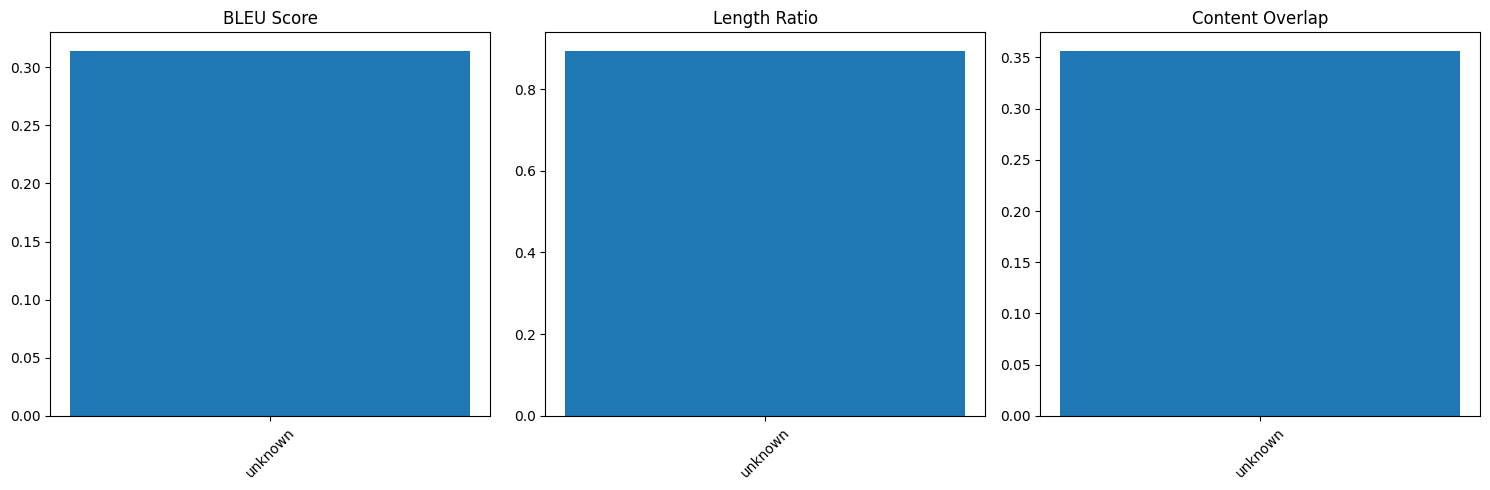

In [28]:
def analyze_chart_performance():
    metrics = defaultdict(lambda: {'bleu': [], 'length_ratio': [], 'content_overlap': []})
    chart_samples = defaultdict(int)
    
    for i, batch in enumerate(val_loader):
        images = batch['images'].to(device)
        captions = batch['captions']
        
        for img_idx, (image, caption) in enumerate(zip(images, captions)):
            # Get prediction
            pred_indices, _ = generate_caption(image)
            pred_text = ' '.join(inv_vocab[idx] for idx in pred_indices).lower()
            actual_text = ' '.join(inv_vocab[idx.item()] for idx in caption if idx.item() not in {0, 2, 3}).lower()
            
            # Calculate metrics
            bleu = sentence_bleu([word_tokenize(actual_text)], word_tokenize(pred_text))
            len_ratio = len(word_tokenize(pred_text)) / len(word_tokenize(actual_text))
            overlap = len(set(word_tokenize(pred_text)) & set(word_tokenize(actual_text))) / len(set(word_tokenize(pred_text)) | set(word_tokenize(actual_text)))
            
            chart_type = batch['chartType'][img_idx] if 'chartType' in batch else "unknown"
            metrics[chart_type]['bleu'].append(bleu)
            metrics[chart_type]['length_ratio'].append(len_ratio)
            metrics[chart_type]['content_overlap'].append(overlap)
            chart_samples[chart_type] += 1
            
            print(f"\n{chart_type} Sample {chart_samples[chart_type]}:")
            print(f"Predicted: {pred_text}")
            print(f"Actual: {actual_text}")
            print(f"BLEU: {bleu:.4f}, Length Ratio: {len_ratio:.2f}, Overlap: {overlap:.2f}")
    
    # Plot metrics
    plot_metrics(metrics)
    return metrics

def plot_metrics(metrics):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    metrics_names = ['bleu', 'length_ratio', 'content_overlap']
    titles = ['BLEU Score', 'Length Ratio', 'Content Overlap']
    
    for i, (metric, title) in enumerate(zip(metrics_names, titles)):
        values = [np.mean(metrics[ct][metric]) for ct in metrics.keys()]
        axes[i].bar(list(metrics.keys()), values)
        axes[i].set_title(title)
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Run analysis
results = analyze_chart_performance()

In [31]:
def analyze_chart_performance():
   metrics = defaultdict(lambda: {'bleu': [], 'length_ratio': [], 'content_overlap': []})
   samples_per_type = defaultdict(int)
   
   for batch_idx, batch in enumerate(val_loader):
       images = batch['images'].to(device)
       captions = batch['captions']
       
       # Get chart types for this batch's samples
       chart_types = val_subset.dataset.metadata.iloc[batch_idx * batch['images'].size(0): 
                                                    (batch_idx + 1) * batch['images'].size(0)]['chartType']
       
       for i, (image, caption, ct) in enumerate(zip(images, captions, chart_types)):
           pred_indices, _ = generate_caption(image)
           pred_text = ' '.join(inv_vocab[idx] for idx in pred_indices)
           actual_text = ' '.join(inv_vocab[idx.item()] for idx in caption if idx.item() not in {0, 2, 3})
           
           # Calculate metrics
           bleu = sentence_bleu([word_tokenize(actual_text)], word_tokenize(pred_text))
           len_ratio = len(word_tokenize(pred_text)) / len(word_tokenize(actual_text))
           overlap = len(set(word_tokenize(pred_text)) & set(word_tokenize(actual_text))) / \
                    len(set(word_tokenize(pred_text)) | set(word_tokenize(actual_text)))
           
           metrics[ct]['bleu'].append(bleu)
           metrics[ct]['length_ratio'].append(len_ratio) 
           metrics[ct]['content_overlap'].append(overlap)
           samples_per_type[ct] += 1
           
           print(f"\n{ct} Sample {samples_per_type[ct]}:")
           print(f"Predicted: {pred_text}")
           print(f"Actual: {actual_text}")
           print(f"BLEU: {bleu:.4f}, Length Ratio: {len_ratio:.2f}, Overlap: {overlap:.2f}")
   
   plot_metrics(metrics)
   return metrics


column Sample 1:
Predicted: this statistic shows the total household expenditure of e-readers in the united states from <unk> to <unk> in <unk> the u.s. <unk> defense costs and containment expenses amounted to approximately <unk> billion u.s. <unk>
Actual: this statistic shows the global unit shipments of e-readers from <unk> to <unk> in <unk> <unk> million units of e-readers were <unk> <unk>
BLEU: 0.3839, Length Ratio: 1.31, Overlap: 0.38

table Sample 1:
Predicted: in fiscal year <unk> the revenue generated by the indian central government from <unk> to <unk> as a result of the <unk> which was <unk> in <unk> the average price generated over the previous <unk> when the revenue generated over the previous <unk> when the revenue generated over the previous
Actual: in fiscal year <unk> the revenue generated by the indian central government from <unk> on tires and tubes was around <unk> billion indian <unk> that <unk> about <unk> percent of the tax revenue was generated from high speed d

c:\Users\prite\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



pie Sample 12:
Predicted: the coronavirus pandemic and resulting fall in the united states <unk> the <unk> of the beginning of <unk> <unk> <unk> to the <unk> <unk> had the <unk> had <unk> to <unk> the <unk> <unk> and <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> and <unk> <unk>
Actual: the outbreak of coronavirus <unk> had a huge impact on the italian book publishing <unk> data based on <unk> publishing houses showed that <unk> works would not <unk> <unk> by <unk> while <unk> works would not be translated from other <unk> into <unk> the reduction in the demand of printed <unk> could result in less <unk> million printed <unk> further information about the coronavirus <unk> <unk> please visit our dedicated fact and figures <unk>
BLEU: 0.2371, Length Ratio: 0.85, Overlap: 0.16

column Sample 14:
Predicted: this statistic shows the number of <unk> <unk> <unk> and <unk> in the united states in <unk> by <unk> in <unk> the <unk> <unk> energy <unk> had the most <unk> <unk> of <unk> and the 

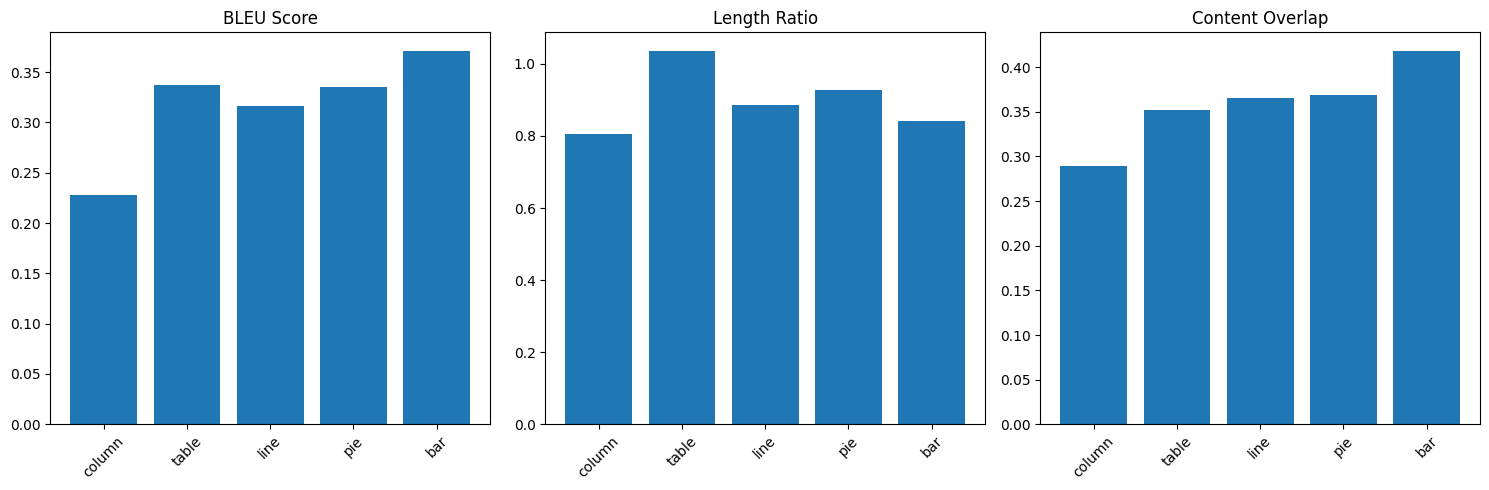

In [32]:
results = analyze_chart_performance()